In [67]:
from rtlsdr import RtlSdr
import numpy as np
import csv
import time
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.io as pio
fig = go.Figure()
pio.renderers.default = "browser"

In [68]:

sdr = RtlSdr()
sdr.sample_rate = 2.5e6  
sdr.center_freq = 92.7e6  
sdr.gain = 19.2
print(sdr.valid_gains_db)
# Number of samples to read in each chunk
num_samples_per_chunk = 1024 * 10  # Read 10240 samples at a time

# How many chunks to capture (for a finite recording)
num_chunks_to_capture = 10
total_samples = num_samples_per_chunk * num_chunks_to_capture
csv_filename = 'rtl_sdr_iq_data.csv'

[-9.9, -4.0, 7.1, 17.9, 19.2]


In [69]:

try:
    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Write header row
        csv_writer.writerow(['Timestamp_ms', 'I_Component', 'Q_Component'])

        start_time_global = time.time()
        for i in range(num_chunks_to_capture):
            # Read samples from the SDR
            samples = sdr.read_samples(num_samples_per_chunk)

            # Get the current timestamp (ms resolution)
            current_timestamp_ms = int((time.time() - start_time_global) * 1000)

            # Prepare data for CSV: [timestamp, I, Q] for each sample
            # samples.real gives the I components, samples.imag gives the Q components
            rows_to_write = []
            for j in range(len(samples)):
                # Calculate individual sample timestamp more accurately if needed,
                # but for bulk recording, a single timestamp per chunk is often fine.
                # For per-sample timestamp:
                sample_time_offset_ms = int((j / sdr.sample_rate) * 1000)
                rows_to_write.append([current_timestamp_ms + sample_time_offset_ms, samples.real[j], samples.imag[j]])
                #rows_to_write.append([current_timestamp_ms, samples.real[j], samples.imag[j]])

            csv_writer.writerows(rows_to_write)
            print(f"Captured chunk {i+1}/{num_chunks_to_capture}. Total samples: {len(samples) * (i+1)}")
finally:
    sdr.close()
    print(f"\nSDR closed. Data saved to {csv_filename}")

print(f"Total time taken: {time.time() - start_time_global:.2f} seconds")

Captured chunk 1/10. Total samples: 10240
Captured chunk 2/10. Total samples: 20480
Captured chunk 3/10. Total samples: 30720
Captured chunk 4/10. Total samples: 40960
Captured chunk 5/10. Total samples: 51200
Captured chunk 6/10. Total samples: 61440
Captured chunk 7/10. Total samples: 71680
Captured chunk 8/10. Total samples: 81920
Captured chunk 9/10. Total samples: 92160
Captured chunk 10/10. Total samples: 102400

SDR closed. Data saved to rtl_sdr_iq_data.csv
Total time taken: 1.41 seconds


In [70]:
data=pd.read_csv('rtl_sdr_iq_data.csv')
print(data.head)

<bound method NDFrame.head of         Timestamp_ms  I_Component  Q_Component
0                  4     0.137255    -0.058824
1                  4     0.678431     0.129412
2                  4     0.286275    -0.160784
3                  4    -0.325490     0.356863
4                  4    -0.121569     0.301961
...              ...          ...          ...
102395          1294     0.239216     0.717647
102396          1294     0.050980    -1.000000
102397          1294     0.207843     0.341176
102398          1294     0.160784     1.000000
102399          1294     0.184314    -0.945098

[102400 rows x 3 columns]>


<bound method NDFrame.head of        Timestamp_ms  I_Component  Q_Component
1                 4     0.678431     0.129412
2                 4     0.286275    -0.160784
3                 4    -0.325490     0.356863
4                 4    -0.121569     0.301961
5                 4    -0.254902     0.192157
...             ...          ...          ...
51195           501     0.529412     0.129412
51196           501     0.921569    -1.000000
51197           501     0.929412    -0.333333
51198           501    -0.074510     0.278431
51199           501     0.403922     1.000000

[51199 rows x 3 columns]>


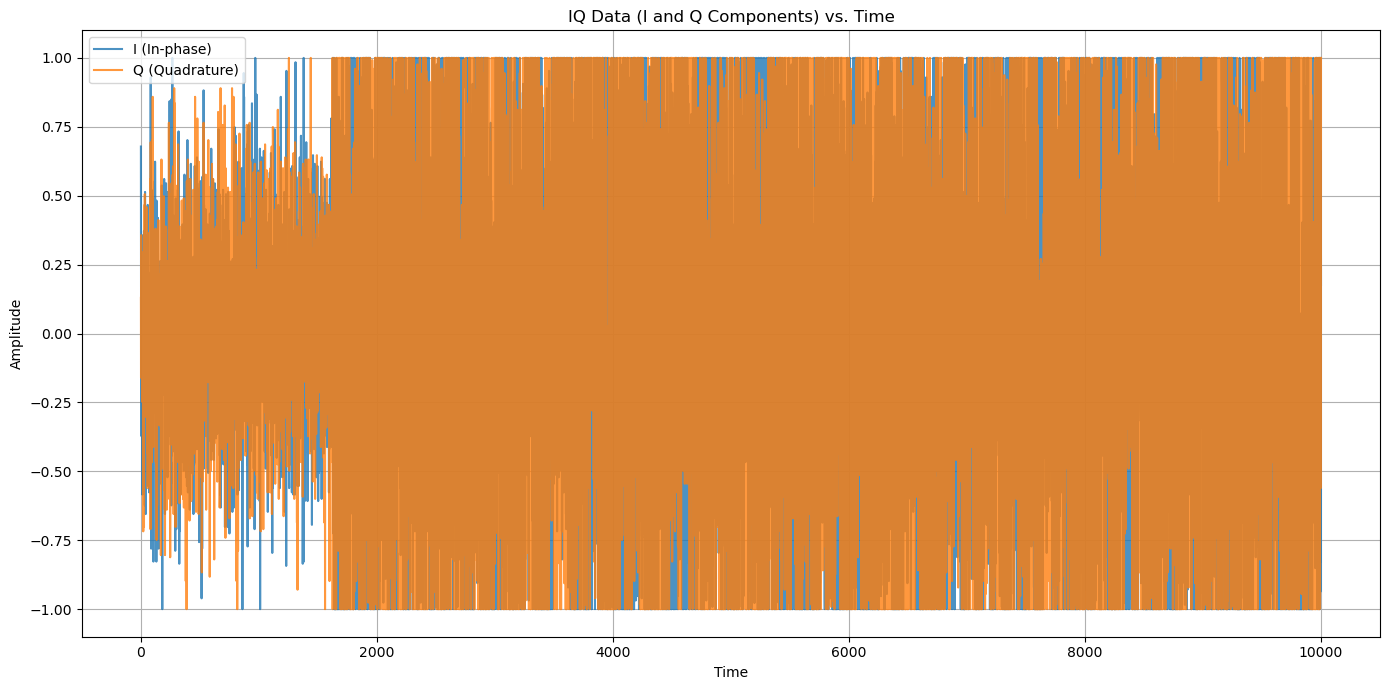

In [71]:
fft_size = 512
num_rows = 100
df=data.iloc[1:fft_size*num_rows]
print(df.head);
plt.figure(figsize=(14, 7))
df1=data.iloc[1:10000]
plt.plot(df1['I_Component'], label='I (In-phase)', alpha=0.8)
plt.plot(df1['Q_Component'], label='Q (Quadrature)', alpha=0.8)

plt.title('IQ Data (I and Q Components) vs. Time')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

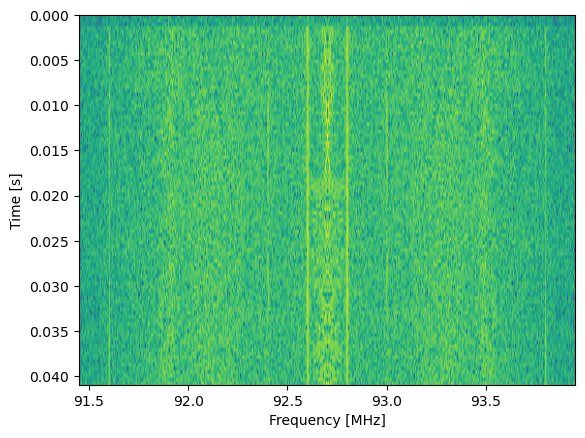

In [72]:

x = data['I_Component']
spectrogram = np.zeros((num_rows, fft_size))
for i in range(num_rows):
    spectrogram[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x[i*fft_size:(i+1)*fft_size])))**2)
extent = [(sdr.center_freq + sdr.sample_rate/-2)/1e6,
            (sdr.center_freq + sdr.sample_rate/2)/1e6,
            len(x)/sdr.sample_rate, 0]
plt.imshow(spectrogram, aspect='auto', extent=extent)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()


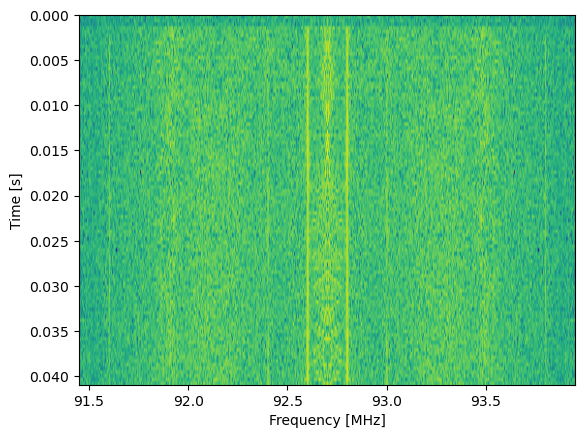

In [74]:
ax = data['Q_Component']
spectrogram = np.zeros((num_rows, fft_size))
for i in range(num_rows):
    spectrogram[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(ax[i*fft_size:(i+1)*fft_size])))**2+1e-10)
extent = [(sdr.center_freq + sdr.sample_rate/-2)/1e6,
            (sdr.center_freq + sdr.sample_rate/2)/1e6,
            len(x)/sdr.sample_rate, 0]
plt.imshow(spectrogram, aspect='auto', extent=extent)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()
